In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1317 files belonging to 4 classes.
Using 1054 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  'data',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1317 files belonging to 4 classes.
Using 263 files for validation.


In [6]:
class_names = val_ds.class_names
print(class_names)

['Albrecht_Dürer', 'Alfred_Sisley', 'Francisco_Goya', 'Pablo_Picasso']


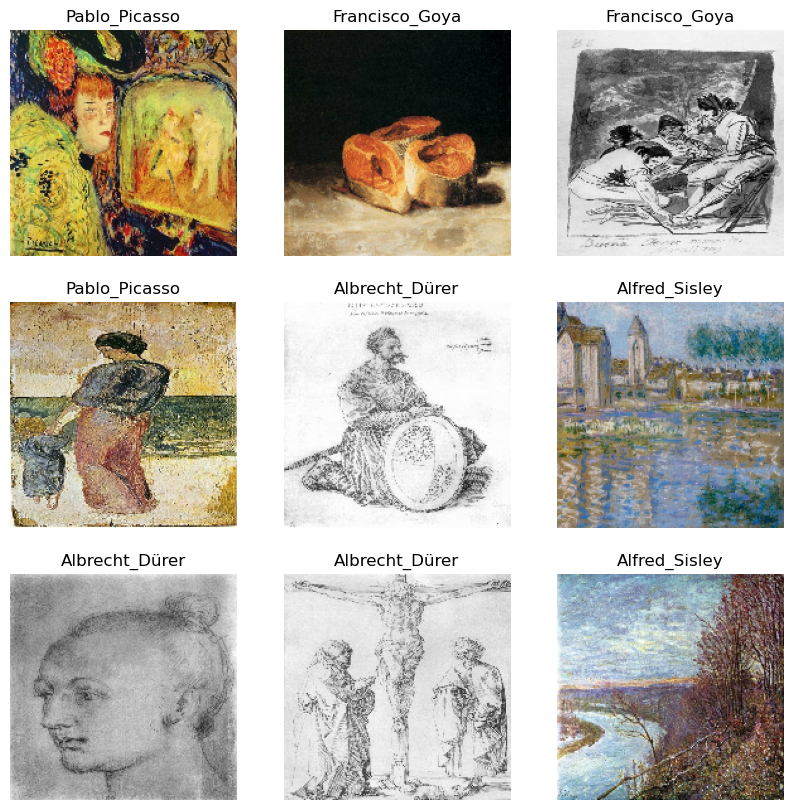

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
33/33 [==============================] - 15s 440ms/step - loss: 1.1583 - accuracy: 0.5569 - val_loss: 1.2256 - val_accuracy: 0.6502
Epoch 2/10
33/33 [==============================] - 16s 470ms/step - loss: 0.7574 - accuracy: 0.7144 - val_loss: 0.6543 - val_accuracy: 0.7795
Epoch 3/10
33/33 [==============================] - 14s 413ms/step - loss: 0.5621 - accuracy: 0.7989 - val_loss: 0.5652 - val_accuracy: 0.8099
Epoch 4/10
33/33 [==============================] - 13s 409ms/step - loss: 0.4133 - accuracy: 0.8719 - val_loss: 0.5857 - val_accuracy: 0.7757
Epoch 5/10
33/33 [==============================] - 14s 434ms/step - loss: 0.3233 - accuracy: 0.8975 - val_loss: 0.5385 - val_accuracy: 0.8403
Epoch 6/10
33/33 [==============================] - 14s 420ms/step - loss: 0.2509 - accuracy: 0.9288 - val_loss: 0.6197 - val_accuracy: 0.8099
Epoch 7/10
33/33 [==============================] - 15s 450ms/step - loss: 0.2313 - accuracy: 0.9336 - val_loss: 0.5838 - val_accuracy: 0.8137

In [ ]:
#Show Training Result

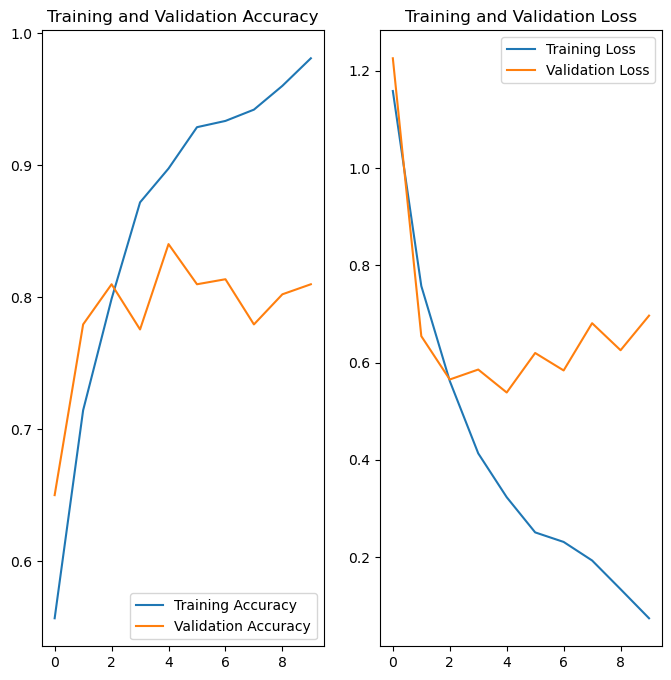

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
mbek_url = "https://galeriemagazine.com/wp-content/uploads/2021/05/Picasso-cover-1920x1200.jpg"

In [25]:
mbek_path = tf.keras.utils.get_file(origin=mbek_url)

img = tf.keras.utils.load_img(
    mbek_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 30ms/step
This image most likely belongs to Pablo_Picasso with a 95.70 percent confidence.


In [26]:
from tensorflow.keras.models import load_model

model.save(os.path.join('model','artmodel.h5'))

In [53]:
new = load_model('model/mbekclassifier.h5')
predictions = new.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 101ms/step
This image most likely belongs to Poll Dorset with a 93.24 percent confidence.
